A better model...

In [1]:
import sympy
import numpy
from matplotlib import pyplot as plt
import ipywidgets
%matplotlib inline

In [4]:
sympy.init_printing()
(u_max, u_star, rho_max,
 rho_star, A, B) = sympy.symbols('u_max u_star rho_max rho_star A B')

In [6]:
# No traffic flux, max density
eq1 = sympy.Eq(0, rho_max*u_max*(1-A*rho_max-B*rho_max**2))
# Max flux at rho_star
eq2 = sympy.Eq(0, u_max*(1-2*A*rho_star-3*B*rho_star**2))
# Velocity at rho_star
eq3 = sympy.Eq(u_star, u_max*(1-A*rho_star-B*rho_star**2))

In [9]:
eq4 = sympy.Eq(eq2.lhs - 3*eq3.lhs, eq2.rhs - 3*eq3.rhs)
eq4

In [10]:
eq4.simplify()

In [13]:
rho_sol = sympy.solve(eq4, rho_star)[0]
rho_sol

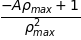

In [15]:
B_sol = sympy.solve(eq1, B)[0]
B_sol

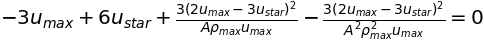

In [18]:
# Substitutes in eq2, rho_sol into rho_star and B_sol as B
quadA = eq2.subs([(rho_star, rho_sol), (B, B_sol)])
quadA.simplify()

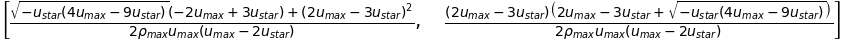

In [19]:
# Solve for A in the quadratic.
A_sol = sympy.solve(quadA, A)
A_sol

In [20]:
# Evaluate the quadratic at the first solved value for A
A_val_0 = A_sol[0].evalf(subs={u_star: 0.7, u_max: 1.0, rho_max: 10.0})
A_val_0

In [22]:
# Evaluate the quadratic at the second solved value for A
A_val_1 = A_sol[1].evalf(subs={u_star: 0.7, u_max: 1.0, rho_max: 10.0})
A_val_1

In [26]:
# Choose the one that is positive.
A_val = max(A_val_0, A_val_1)
A_val

In [27]:
B_val = B_sol.evalf(subs={rho_max: 10.0, A: A_val})
B_val

In [46]:
def cubic_flux(rho, u_max, A, B):
    F = rho*u_max*(1.0 - A*rho - B*rho**2)
    return F

In [134]:
rho_max = 5.0
u_max = 1.0

L = 4.0
nx = 81
dx = L/(nx-1)
x = numpy.linspace(0.0,L,num=nx)
nt = 30
sigma = 1
dt = sigma*(dx/u_max)

In [135]:
plt.rcParams['font.family']='serif'
plt.rcParams['font.size'] = 16

In [136]:
rho0 = numpy.zeros_like(x)
mask = numpy.where(x < 2.0)
rho0[mask] = rho_max*x[mask]/2

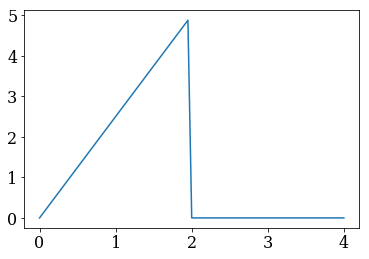

In [137]:
plt.plot(x, rho0)

In [151]:
def ftbs(rho0, nt, dt, dx, A, B):
    rho = rho0.copy()
    rho_hist = [rho.copy()]
    for n in range(nt):
        #rho_new = rho.copy()
        F = cubic_flux(rho, u_max, A, B)
        rho[1:] = rho[1:] - (dt/dx)*(F[1:]-F[:-1])
        
        rho_hist.append(rho)
        
    return rho_hist
    

In [152]:
sol = ftbs(rho0, nt, dt, dx, A_val, B_val)

In [140]:
def myfunction(*args):
    print(type(args))
    print(*args)
    return

In [141]:
myfunction(1)

<class 'tuple'>
1


In [142]:
def lax_freidrichs(rho0, nt, dt, dx, u_max, rho_max, A, B):
    rho_hist = [numpy.copy(rho0)]
    rho = rho0.copy()
    nx = len(rho0)
    for j in range(nt):
        rhon = rho.copy()
        F = cubic_flux(rhon, u_max, A, B)
#         for i in range(1, nx-1):
#             rho[i] = 0.5*(rhon[i-1] + rho[i+1]) - (dt/(2*dx)) * (F[i+1] - F[i-1])
        rho[1:-1] = 0.5 * (rhon[:-2] + rhon[2:]) - dt * (F[2:] - F[:-2] / dx)
        rho_hist.append(rho.copy())
        
    return rho_hist # List of numpy arrays

In [149]:
sol2 = lax_freidrichs(rho0, nt, dt, dx, u_max, rho_max, A_val, B_val)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in square
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in add
  # Remove the CWD from sys.path while we load stuff.


In [144]:
def interactive_plot(x, rho_hist):
    nt = len(rho_hist) - 1
    nt_slider = ipywidgets.IntSlider(value=0, min=0, max=nt, step=1,
                                     description='Time step')
    w = ipywidgets.interactive(plot, n=nt_slider,
                              x=ipywidgets.fixed(x),
                              rho_hist=ipywidgets.fixed(rho_hist))
    
    return w

In [145]:
def plot(n, x, rho_hist):
    plt.figure()
    plt.grid()
    plt.title('Time step: {}'.format(n))
    plt.xlabel('Road [km]')
    plt.ylabel('Traffic density [cars/hr]')
    plt.plot(x, rho_hist[n])
    plt.xlim(x[0], x[-1])
    plt.ylim(0.0, 11.0)
    plt.show()

In [148]:
interactive_plot(x, sol)

interactive(children=(IntSlider(value=0, description='Time step', max=30), Output()), _dom_classes=('widget-in…